# 📊 Customer Clustering - Model Evaluation

This notebook provides comprehensive evaluation and comparison of all trained clustering models.

## Evaluation Sections:
1. **Load Models & Results** - Import all trained models
2. **Performance Metrics** - Detailed metric comparison
3. **Cluster Visualization (2D/3D)** - PCA and t-SNE projections
4. **Cluster Profiles** - Analyze characteristics of each cluster
5. **Silhouette Analysis** - Per-cluster silhouette scores
6. **Cluster Size Distribution** - Balance analysis
7. **Feature Importance** - Which features drive clustering?
8. **Business Insights** - Actionable customer segments

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from matplotlib.patches import Patch

# Clustering and metrics
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Statistics
from scipy.spatial.distance import cdist

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## 📂 Load Data, Models, and Results

In [2]:
# Load scaled data
print("Loading data...")
df_scaled = pd.read_csv('clustering_scaled_standard.csv')
X = df_scaled.values

print(f"Data shape: {X.shape}")
print(f"Features: {X.shape[1]}")
print(f"Samples: {X.shape[0]:,}")

# Load original cleaned data for profiling
df_original = pd.read_csv('clustering_cleaned.csv')
print(f"\n✓ Original data loaded for cluster profiling")

Loading data...
Data shape: (8636, 17)
Features: 17
Samples: 8,636

✓ Original data loaded for cluster profiling


In [ ]:
# Data quality check
print("Checking data quality...")

# Check scaled data
print(f"\nScaled data:")
print(f"  Shape: {df_scaled.shape}")
print(f"  Missing values: {df_scaled.isnull().sum().sum()}")
print(f"  Infinite values: {np.isinf(df_scaled.values).sum()}")

# Check original data
print(f"\nOriginal data:")
print(f"  Shape: {df_original.shape}")
print(f"  Data types: {df_original.dtypes.value_counts().to_dict()}")
print(f"  Numeric columns: {len(df_original.select_dtypes(include=[np.number]).columns)}")
print(f"  Non-numeric columns: {len(df_original.select_dtypes(exclude=[np.number]).columns)}")

if len(df_original.select_dtypes(exclude=[np.number]).columns) > 0:
    print(f"  Non-numeric column names: {list(df_original.select_dtypes(exclude=[np.number]).columns)}")

print("\n✓ Data quality check complete!")

In [4]:
# Load clustering results
print("\nLoading clustering results...")

with open('all_clustering_results.pkl', 'rb') as f:
    all_results = pickle.load(f)

# Load labels
labels_df = pd.read_csv('clustering_labels.csv')

# Load comparison results
comparison_df = pd.read_csv('clustering_results.csv')

print(f"✓ Loaded results for {len(all_results)} models")
print(f"\nModels: {list(labels_df.columns)}")


Loading clustering results...
✓ Loaded results for 6 models

Models: ['K-Means', 'Mini-Batch K-Means', 'Agglomerative', 'DBSCAN', 'GMM', 'Spectral']


## 📊 Section 1: Performance Metrics Summary

In [5]:
# Display detailed comparison
print("="*80)
print("CLUSTERING MODELS - PERFORMANCE COMPARISON")
print("="*80)

display(comparison_df.style.background_gradient(subset=['Silhouette'], cmap='Greens')
                           .background_gradient(subset=['Calinski-Harabasz'], cmap='Blues'))

# Identify best models
print("\n" + "="*80)
print("🏆 BEST MODELS BY METRIC")
print("="*80)

best_silhouette = comparison_df.loc[comparison_df['Silhouette'].idxmax()]
print(f"\n✨ Best Silhouette Score: {best_silhouette['Model']} ({best_silhouette['Silhouette']:.4f})")

best_calinski = comparison_df.loc[comparison_df['Calinski-Harabasz'].idxmax()]
print(f"✨ Best Calinski-Harabasz: {best_calinski['Model']} ({best_calinski['Calinski-Harabasz']:.2f})")

# Davies-Bouldin (lower is better)
db_valid = comparison_df[comparison_df['Davies-Bouldin'] != float('inf')]
if len(db_valid) > 0:
    best_db = db_valid.loc[db_valid['Davies-Bouldin'].idxmin()]
    print(f"✨ Best Davies-Bouldin: {best_db['Model']} ({best_db['Davies-Bouldin']:.4f})")

CLUSTERING MODELS - PERFORMANCE COMPARISON


,Model,N_Clusters,Noise_Points,Training_Time,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,K-Means,3,0,0.09s,0.247097,1546.528220,1.605443
1,Mini-Batch K-Means,3,0,0.03s,0.207430,1511.868320,1.673163
2,Agglomerative Clustering,3,0,3.01s,0.178453,1296.052863,1.784822
3,Spectral Clustering,3,0,5.05s,0.161097,1218.024894,1.761050
4,Gaussian Mixture Model,3,0,0.37s,0.115123,887.558601,2.627679
5,DBSCAN,36,6488,0.08s,-0.311034,46.632166,0.962680



🏆 BEST MODELS BY METRIC

✨ Best Silhouette Score: K-Means (0.2471)
✨ Best Calinski-Harabasz: K-Means (1546.53)
✨ Best Davies-Bouldin: DBSCAN (0.9627)


## 🎨 Section 2: Cluster Visualizations (2D & 3D)

In [6]:
# Apply PCA for 2D visualization
print("Applying PCA for 2D visualization...")
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X)

explained_var_2d = pca_2d.explained_variance_ratio_
print(f"✓ PCA 2D: {explained_var_2d[0]*100:.2f}% + {explained_var_2d[1]*100:.2f}% = {sum(explained_var_2d)*100:.2f}% variance explained")

# Apply PCA for 3D visualization
print("\nApplying PCA for 3D visualization...")
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X)

explained_var_3d = pca_3d.explained_variance_ratio_
print(f"✓ PCA 3D: {sum(explained_var_3d)*100:.2f}% variance explained")

Applying PCA for 2D visualization...
✓ PCA 2D: 27.23% + 20.37% = 47.61% variance explained

Applying PCA for 3D visualization...
✓ PCA 3D: 56.52% variance explained


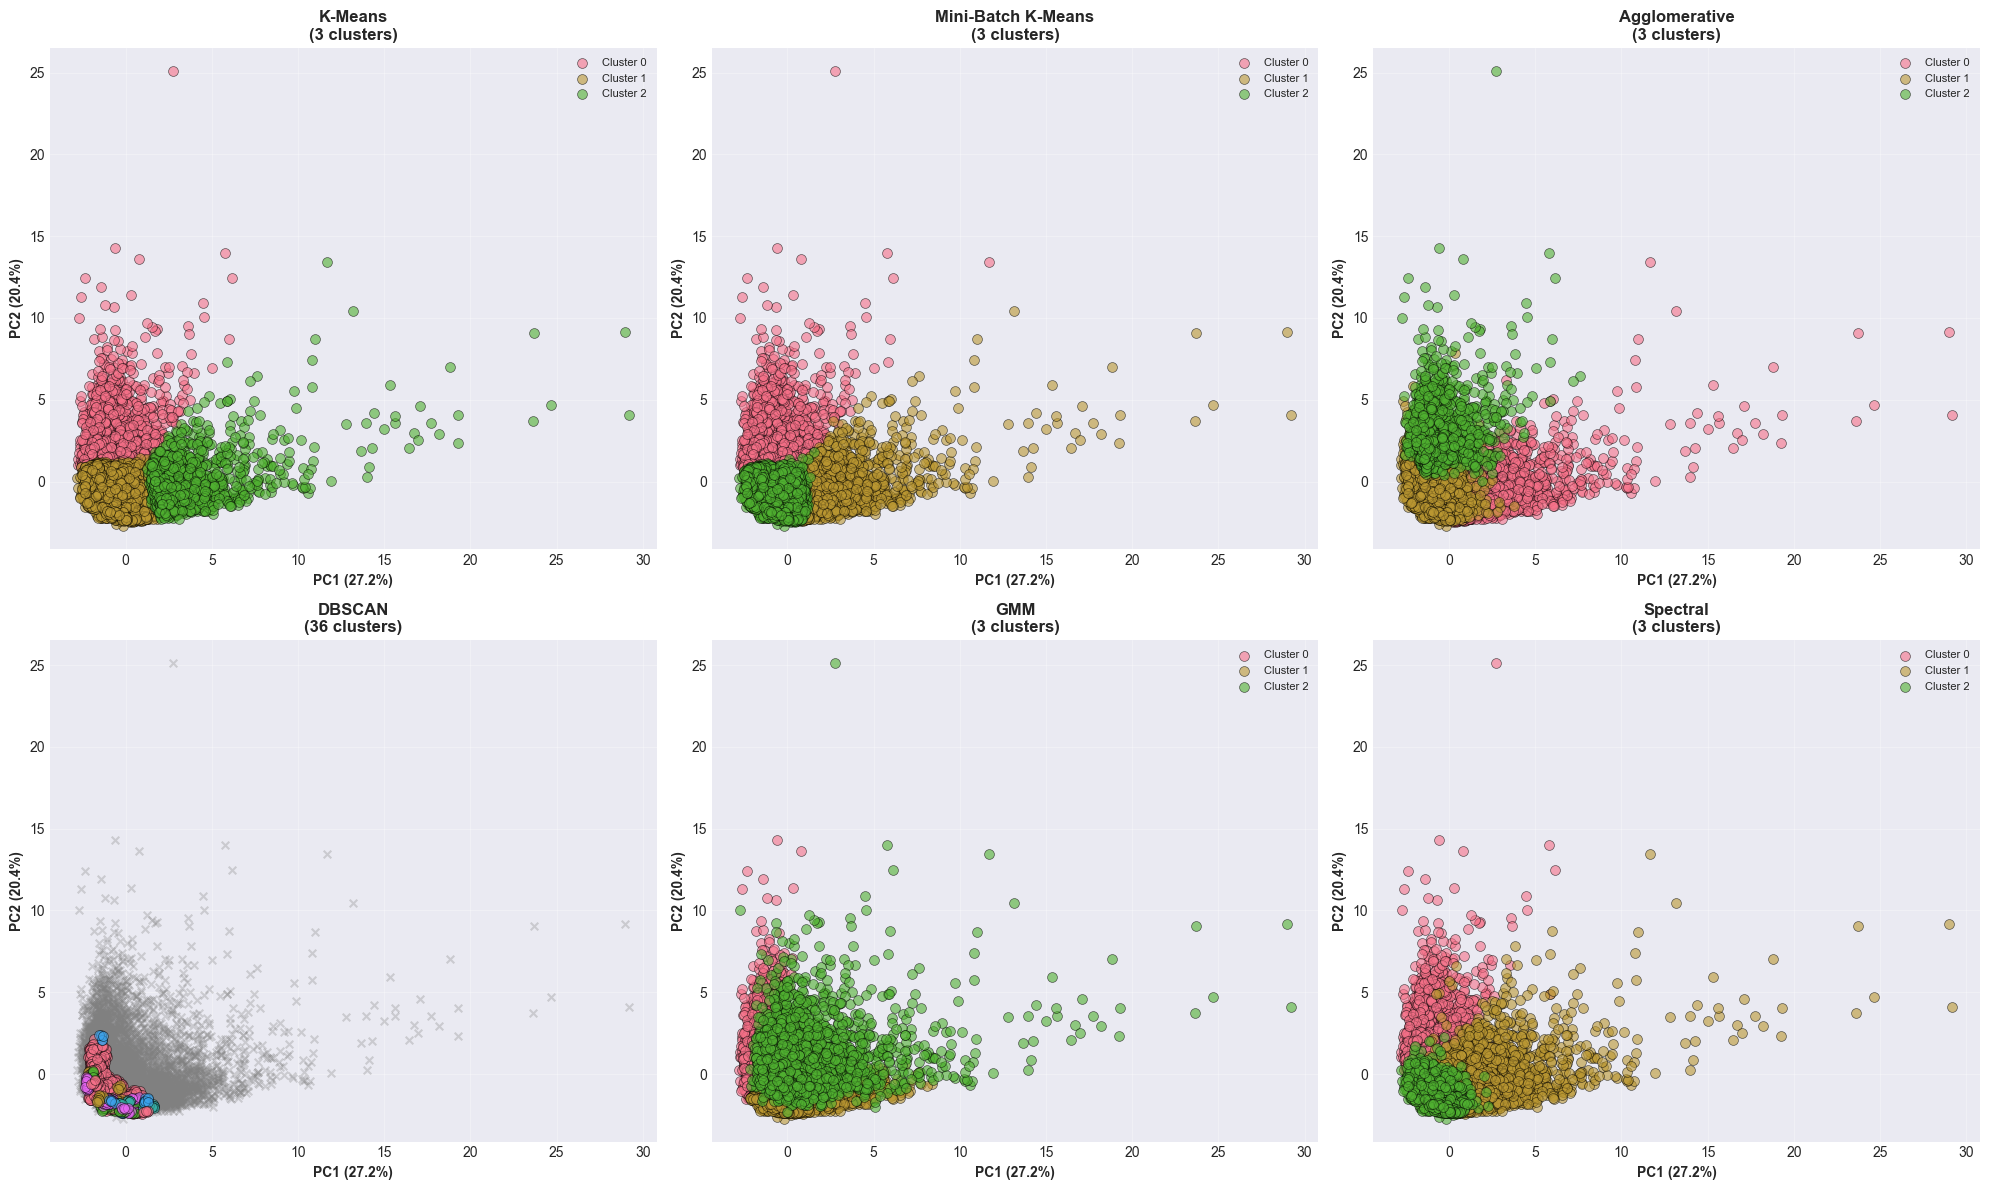


✓ 2D PCA visualization saved: clusters_pca_2d.png


In [7]:
# 2D PCA Visualization for all models
model_names = list(labels_df.columns)
n_models = len(model_names)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, model_name in enumerate(model_names):
    ax = axes[idx]
    labels = labels_df[model_name].values
    
    # Get unique clusters (exclude noise if present)
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels[unique_labels >= 0])
    
    # Plot clusters
    for label in unique_labels:
        if label == -1:
            # Noise points (DBSCAN)
            mask = labels == label
            ax.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
                      c='gray', marker='x', s=30, alpha=0.3, label='Noise')
        else:
            mask = labels == label
            ax.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
                      s=50, alpha=0.6, label=f'Cluster {label}', edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel(f'PC1 ({explained_var_2d[0]*100:.1f}%)', fontweight='bold')
    ax.set_ylabel(f'PC2 ({explained_var_2d[1]*100:.1f}%)', fontweight='bold')
    ax.set_title(f'{model_name}\n({n_clusters} clusters)', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
    
    # Add legend if not too many clusters
    if n_clusters <= 10:
        ax.legend(loc='best', fontsize=8, framealpha=0.9)

plt.tight_layout()
plt.savefig('clusters_pca_2d.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ 2D PCA visualization saved: clusters_pca_2d.png")

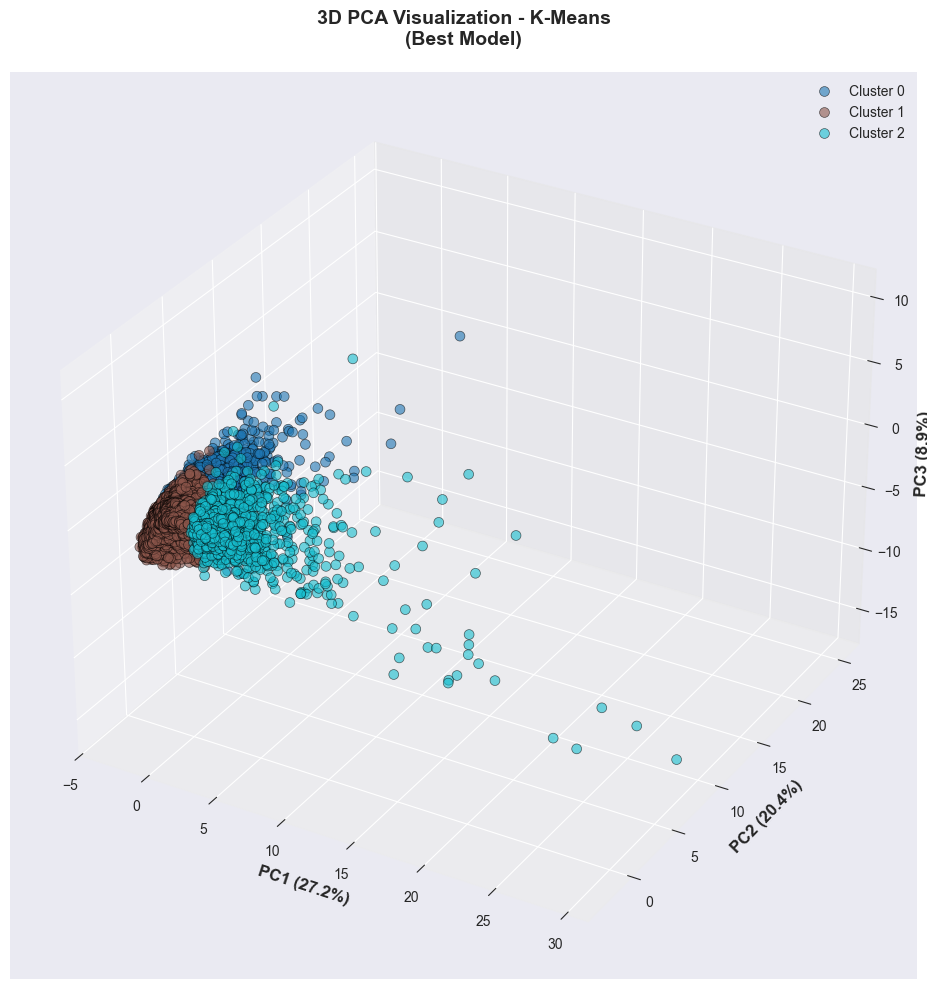


✓ 3D visualization saved: clusters_pca_3d_best.png


In [8]:
# 3D PCA Visualization for best model
from mpl_toolkits.mplot3d import Axes3D

best_model_name = comparison_df.iloc[0]['Model']
best_labels = labels_df[best_model_name].values

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

unique_labels = np.unique(best_labels[best_labels >= 0])
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

for idx, label in enumerate(unique_labels):
    mask = best_labels == label
    ax.scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], X_pca_3d[mask, 2],
              c=[colors[idx]], s=50, alpha=0.6, label=f'Cluster {label}', 
              edgecolors='black', linewidth=0.5)

# Handle noise points if present
if -1 in best_labels:
    mask = best_labels == -1
    ax.scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], X_pca_3d[mask, 2],
              c='gray', marker='x', s=30, alpha=0.3, label='Noise')

ax.set_xlabel(f'PC1 ({explained_var_3d[0]*100:.1f}%)', fontweight='bold', fontsize=12)
ax.set_ylabel(f'PC2 ({explained_var_3d[1]*100:.1f}%)', fontweight='bold', fontsize=12)
ax.set_zlabel(f'PC3 ({explained_var_3d[2]*100:.1f}%)', fontweight='bold', fontsize=12)
ax.set_title(f'3D PCA Visualization - {best_model_name}\n(Best Model)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=10)

plt.tight_layout()
plt.savefig('clusters_pca_3d_best.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 3D visualization saved: clusters_pca_3d_best.png")

## 📈 Section 3: Silhouette Analysis

SILHOUETTE ANALYSIS - K-Means


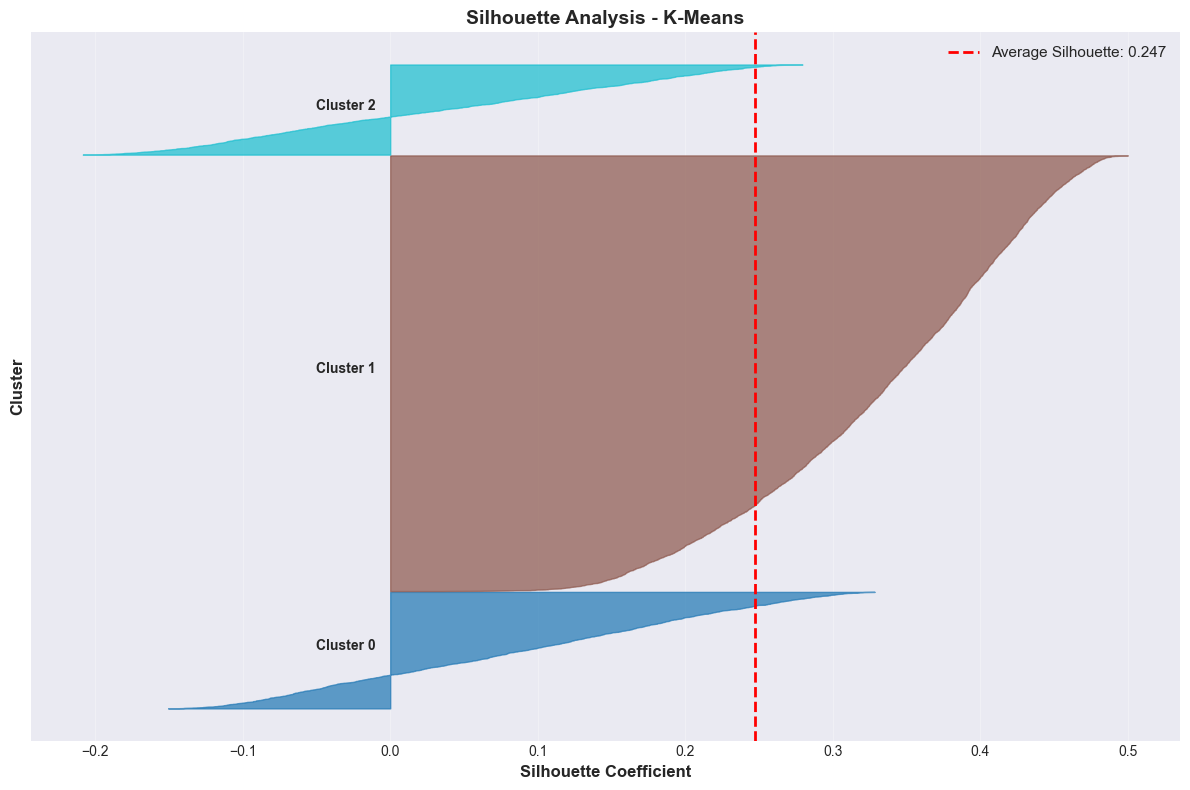


✓ Silhouette analysis saved: silhouette_analysis.png

Average Silhouette Score: 0.2471

Per-Cluster Silhouette Scores:
  Cluster 0: 0.0890 (1,567 samples)
  Cluster 1: 0.3329 (5,857 samples)
  Cluster 2: 0.0370 (1,212 samples)


In [9]:
# Detailed silhouette analysis for best model
print("="*80)
print(f"SILHOUETTE ANALYSIS - {best_model_name}")
print("="*80)

# Calculate silhouette scores for each sample
mask = best_labels >= 0  # Exclude noise
sample_silhouette_values = silhouette_samples(X[mask], best_labels[mask])

# Create silhouette plot
fig, ax = plt.subplots(figsize=(12, 8))

y_lower = 10
unique_labels = np.unique(best_labels[best_labels >= 0])
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

for idx, label in enumerate(unique_labels):
    # Get silhouette scores for this cluster
    cluster_mask = best_labels[mask] == label
    cluster_silhouette_values = sample_silhouette_values[cluster_mask]
    cluster_silhouette_values.sort()
    
    size_cluster = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster
    
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values,
                     facecolor=colors[idx], edgecolor=colors[idx], alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster, f'Cluster {label}', 
            fontsize=10, fontweight='bold')
    
    y_lower = y_upper + 10

# Overall average silhouette score
avg_silhouette = silhouette_score(X[mask], best_labels[mask])
ax.axvline(x=avg_silhouette, color='red', linestyle='--', linewidth=2, 
           label=f'Average Silhouette: {avg_silhouette:.3f}')

ax.set_xlabel('Silhouette Coefficient', fontweight='bold', fontsize=12)
ax.set_ylabel('Cluster', fontweight='bold', fontsize=12)
ax.set_title(f'Silhouette Analysis - {best_model_name}', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.set_yticks([])
ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('silhouette_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Silhouette analysis saved: silhouette_analysis.png")
print(f"\nAverage Silhouette Score: {avg_silhouette:.4f}")

# Per-cluster statistics
print("\nPer-Cluster Silhouette Scores:")
for label in unique_labels:
    cluster_mask = best_labels[mask] == label
    cluster_silhouette = sample_silhouette_values[cluster_mask].mean()
    cluster_size = cluster_mask.sum()
    print(f"  Cluster {label}: {cluster_silhouette:.4f} ({cluster_size:,} samples)")

## 📦 Section 4: Cluster Size Distribution

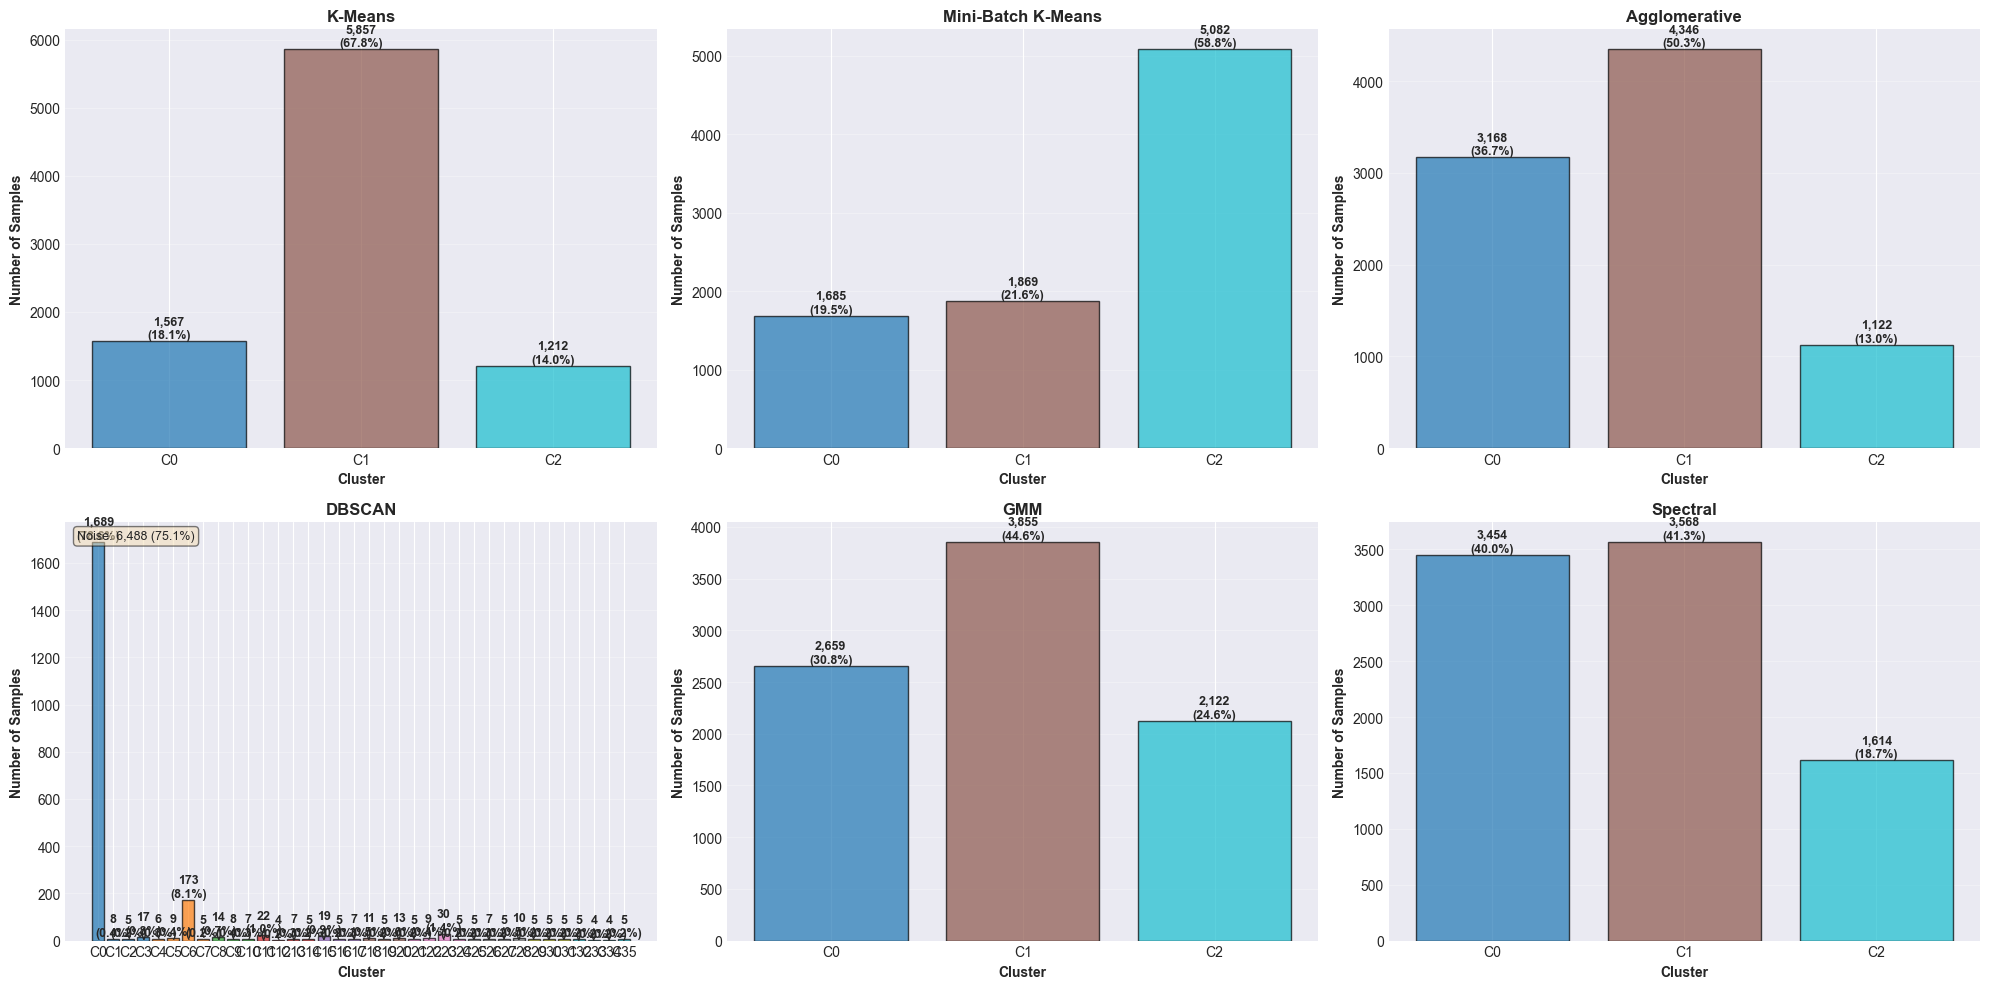


✓ Cluster size distribution saved: cluster_size_distribution.png


In [10]:
# Cluster size distribution for all models
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

for idx, model_name in enumerate(model_names):
    ax = axes[idx]
    labels = labels_df[model_name].values
    
    # Count samples per cluster
    unique, counts = np.unique(labels[labels >= 0], return_counts=True)
    
    # Create bar plot
    bars = ax.bar([f'C{l}' for l in unique], counts, alpha=0.7, edgecolor='black')
    
    # Color bars
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique)))
    for bar, color in zip(bars, colors):
        bar.set_facecolor(color)
    
    # Add percentage labels
    total = counts.sum()
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{count:,}\n({count/total*100:.1f}%)',
               ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Handle noise
    n_noise = np.sum(labels == -1)
    if n_noise > 0:
        ax.text(0.02, 0.98, f'Noise: {n_noise:,} ({n_noise/len(labels)*100:.1f}%)',
               transform=ax.transAxes, va='top', fontsize=9,
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_xlabel('Cluster', fontweight='bold')
    ax.set_ylabel('Number of Samples', fontweight='bold')
    ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('cluster_size_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Cluster size distribution saved: cluster_size_distribution.png")

## 🔍 Section 5: Cluster Profiling (Best Model)

In [ ]:
# Create cluster profiles using original data
print("="*80)
print(f"CLUSTER PROFILING - {best_model_name}")
print("="*80)

# Add cluster labels to original data
df_profiling = df_original.copy()

# Select only numeric columns for profiling
numeric_cols = df_profiling.select_dtypes(include=[np.number]).columns.tolist()
df_profiling = df_profiling[numeric_cols]

# Add cluster labels
df_profiling['Cluster'] = best_labels

# Remove noise points if any
df_profiling_clean = df_profiling[df_profiling['Cluster'] >= 0]

print(f"\nProfiling {len(numeric_cols)} numeric features across {len(df_profiling_clean['Cluster'].unique())} clusters")
print(f"Total samples: {len(df_profiling_clean):,}")

# Calculate statistics per cluster
cluster_profiles = df_profiling_clean.groupby('Cluster').agg(['mean', 'std', 'min', 'max'])

print("\nCluster Profiles (Mean values):")
display(cluster_profiles.xs('mean', level=1, axis=1).style.background_gradient(cmap='YlOrRd'))

# Save profiles
cluster_profiles.to_csv('cluster_profiles.csv')
print("\n✓ Cluster profiles saved: cluster_profiles.csv")

CLUSTER PROFILING - K-Means


TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
# Visualize cluster profiles with radar chart
from math import pi

# Get mean values for each cluster (only numeric columns)
cluster_means = df_profiling_clean.groupby('Cluster').mean()
features = cluster_means.columns.tolist()
n_features = len(features)

# Limit features for readability (use top 8 most important)
if n_features > 8:
    # Calculate variance between clusters to find most important features
    feature_variance = cluster_means.var(axis=0).sort_values(ascending=False)
    top_features = feature_variance.head(8).index.tolist()
    cluster_means = cluster_means[top_features]
    features = top_features
    n_features = len(features)
    print(f"Using top {n_features} most important features for radar chart")

# Normalize to 0-1 for radar chart
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cluster_means_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_means),
    columns=features,
    index=cluster_means.index
)

# Create radar chart for each cluster
n_clusters = len(cluster_means_scaled)
angles = [n / float(n_features) * 2 * pi for n in range(n_features)]
angles += angles[:1]

n_plots = min(n_clusters, 3)
fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 6), 
                        subplot_kw=dict(projection='polar'))

if n_plots == 1:
    axes = [axes]

for idx, cluster_id in enumerate(cluster_means_scaled.index[:n_plots]):
    ax = axes[idx] if n_plots > 1 else axes[0]
    values = cluster_means_scaled.loc[cluster_id].values.tolist()
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster_id}')
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, size=9)
    ax.set_ylim(0, 1)
    ax.set_title(f'Cluster {cluster_id} Profile', size=12, fontweight='bold', pad=20)
    ax.grid(True)

plt.tight_layout()
plt.savefig('cluster_profiles_radar.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Radar chart saved: cluster_profiles_radar.png")

## 🎯 Section 6: Feature Importance for Clustering

In [ ]:
# Calculate feature variance between clusters
print("="*80)
print("FEATURE IMPORTANCE FOR CLUSTERING")
print("="*80)

# Calculate variance between cluster means (using only numeric columns)
cluster_means = df_profiling_clean.drop('Cluster', axis=1).groupby(df_profiling_clean['Cluster']).mean()
feature_variance = cluster_means.var(axis=0).sort_values(ascending=False)

print("\nFeature Variance Between Clusters (Higher = More Important):")
print(feature_variance)

# Visualize
fig, ax = plt.subplots(figsize=(12, max(6, len(feature_variance) * 0.3)))
bars = ax.barh(range(len(feature_variance)), feature_variance.values, alpha=0.7, color='steelblue', edgecolor='black')

# Color bars by importance
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(feature_variance)))
for bar, color in zip(bars, colors):
    bar.set_facecolor(color)

ax.set_yticks(range(len(feature_variance)))
ax.set_yticklabels(feature_variance.index)
ax.set_xlabel('Variance Between Cluster Means', fontweight='bold', fontsize=12)
ax.set_ylabel('Feature', fontweight='bold', fontsize=12)
ax.set_title('Feature Importance for Clustering', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='x')
ax.invert_yaxis()

# Add value labels
for i, (bar, value) in enumerate(zip(bars, feature_variance.values)):
    ax.text(value, bar.get_y() + bar.get_height()/2, f' {value:.4f}',
           va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance saved: feature_importance.png")

## 💼 Section 7: Business Insights & Customer Segments

In [ ]:
# Generate business insights
print("="*80)
print("BUSINESS INSIGHTS & CUSTOMER SEGMENTATION")
print("="*80)

unique_clusters = np.unique(best_labels[best_labels >= 0])

# Use numeric columns only
numeric_cols_only = [col for col in df_profiling_clean.columns if col != 'Cluster']

# For each cluster, identify key characteristics
for cluster_id in unique_clusters:
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster_id} - CUSTOMER SEGMENT")
    print(f"{'='*60}")
    
    cluster_data = df_profiling_clean[df_profiling_clean['Cluster'] == cluster_id]
    cluster_size = len(cluster_data)
    cluster_pct = cluster_size / len(df_profiling_clean) * 100
    
    print(f"\n📊 Size: {cluster_size:,} customers ({cluster_pct:.1f}% of total)")
    
    # Find distinguishing features (highest deviation from overall mean)
    overall_mean = df_profiling_clean[numeric_cols_only].mean()
    cluster_mean = cluster_data[numeric_cols_only].mean()
    
    # Calculate absolute percentage deviation
    deviations = ((cluster_mean - overall_mean) / (overall_mean + 1e-10) * 100).abs().sort_values(ascending=False)
    
    print(f"\n🔍 Top 5 Distinguishing Features:")
    for feature in deviations.head(5).index:
        cluster_val = cluster_mean[feature]
        overall_val = overall_mean[feature]
        deviation = deviations[feature]
        direction = "higher" if cluster_val > overall_val else "lower"
        print(f"   • {feature}: {cluster_val:.2f} vs avg {overall_val:.2f} ({deviation:.1f}% {direction})")
    
    # Statistical summary (show top 5 features only for readability)
    print(f"\n📈 Key Statistics (Top 5 Features):")
    summary = cluster_data[deviations.head(5).index].describe().loc[['mean', 'std', 'min', 'max']]
    print(summary.T.to_string())

print("\n" + "="*80)
print("✅ BUSINESS INSIGHTS COMPLETE")
print("="*80)
print("\n💡 TIP: Use these insights to develop targeted marketing strategies for each segment!")

## 📝 Section 8: Final Summary Report

In [ ]:
# Generate comprehensive summary report
print("="*80)
print("📊 CLUSTERING EVALUATION - FINAL SUMMARY REPORT")
print("="*80)

print("\n1️⃣ MODELS EVALUATED")
print(f"   Total models: {len(all_results)}")
print(f"   Models: {', '.join(model_names)}")

print("\n2️⃣ BEST PERFORMING MODEL")
print(f"   🏆 Model: {best_model_name}")
print(f"   📊 Silhouette Score: {best_silhouette['Silhouette']:.4f}")
print(f"   📊 Calinski-Harabasz: {best_silhouette['Calinski-Harabasz']:.2f}")
print(f"   📊 Number of Clusters: {best_silhouette['N_Clusters']}")

print("\n3️⃣ CLUSTER CHARACTERISTICS")
for cluster_id in unique_clusters:
    cluster_size = len(df_profiling_clean[df_profiling_clean['Cluster'] == cluster_id])
    cluster_pct = cluster_size / len(df_profiling_clean) * 100
    print(f"   • Cluster {cluster_id}: {cluster_size:,} customers ({cluster_pct:.1f}%)")

print("\n4️⃣ DATA QUALITY")
print(f"   • Total samples: {len(X):,}")
print(f"   • Features: {X.shape[1]}")
print(f"   • Noise points: {np.sum(best_labels == -1)} ({np.sum(best_labels == -1)/len(best_labels)*100:.2f}%)")

print("\n5️⃣ OUTPUT FILES CREATED")
print("   ✅ clustering_results.csv - Model comparison")
print("   ✅ cluster_profiles.csv - Cluster characteristics")
print("   ✅ clusters_pca_2d.png - 2D visualizations")
print("   ✅ clusters_pca_3d_best.png - 3D visualization")
print("   ✅ silhouette_analysis.png - Silhouette plot")
print("   ✅ cluster_size_distribution.png - Size distribution")
print("   ✅ cluster_profiles_radar.png - Radar charts")
print("   ✅ feature_importance.png - Feature analysis")

print("\n6️⃣ RECOMMENDATIONS")
print(f"   📌 Use {best_model_name} for production")
print(f"   📌 Focus on top {min(5, len(feature_variance))} distinguishing features")
print(f"   📌 Develop targeted strategies for each of {len(unique_clusters)} customer segments")
print(f"   📌 Monitor cluster stability over time")

print("\n" + "="*80)
print("✅ CLUSTERING EVALUATION COMPLETE!")
print("="*80)

## 💾 Export Final Results

In [ ]:
# Export data with cluster assignments
print("Exporting final results...")

# Add best model's clusters to original data
df_final = df_original.copy()
df_final['Cluster'] = best_labels
df_final['Model'] = best_model_name

# Save
df_final.to_csv('customers_with_clusters.csv', index=False)
print("✓ Final dataset with clusters saved: customers_with_clusters.csv")

# Also save a numeric-only version for further analysis
numeric_cols = df_original.select_dtypes(include=[np.number]).columns.tolist()
df_final_numeric = df_original[numeric_cols].copy()
df_final_numeric['Cluster'] = best_labels
df_final_numeric.to_csv('customers_with_clusters_numeric.csv', index=False)
print("✓ Numeric-only dataset saved: customers_with_clusters_numeric.csv")

# Save summary statistics
summary_stats = {
    'Best_Model': best_model_name,
    'N_Clusters': len(unique_clusters),
    'Silhouette_Score': float(best_silhouette['Silhouette']),
    'Calinski_Harabasz': float(best_silhouette['Calinski-Harabasz']),
    'Davies_Bouldin': float(best_silhouette['Davies-Bouldin']),
    'Total_Samples': len(X),
    'Noise_Points': int(np.sum(best_labels == -1)),
    'Total_Features': X.shape[1],
    'Numeric_Features': len(numeric_cols)
}

with open('clustering_summary.txt', 'w') as f:
    f.write("CLUSTERING EVALUATION SUMMARY\n")
    f.write("=" * 50 + "\n\n")
    for key, value in summary_stats.items():
        f.write(f"{key}: {value}\n")
    
    f.write("\n" + "=" * 50 + "\n")
    f.write("CLUSTER SIZES\n")
    f.write("=" * 50 + "\n")
    for cluster_id in unique_clusters:
        cluster_size = len(df_profiling_clean[df_profiling_clean['Cluster'] == cluster_id])
        cluster_pct = cluster_size / len(df_profiling_clean) * 100
        f.write(f"Cluster {cluster_id}: {cluster_size:,} ({cluster_pct:.1f}%)\n")

print("✓ Summary statistics saved: clustering_summary.txt")
print("\n🎉 All results exported successfully!")
print(f"\n📁 Files created:")
print(f"   • customers_with_clusters.csv - Full dataset with cluster labels")
print(f"   • customers_with_clusters_numeric.csv - Numeric features only")
print(f"   • clustering_summary.txt - Summary statistics")